In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
from bs4 import BeautifulSoup
import re

抓股票代號

In [2]:
#抓美國市值前一百的股票代號
US100_stocks = []
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36",
    "scheme" : 'https',
    "path" : '/tw/image/Goodinfo.ico', 
    "Referer" : 'https://goodinfo.tw/tw/StockDetail.asp?STOCK_ID=0051',
    "Cookie" : 'CLIENT%5FID=20230920214311062%5F140%2E117%2E80%2E123; IS_TOUCH_DEVICE=F; SCREEN_SIZE=WIDTH=1920&HEIGHT=1080; TW_STOCK_BROWSE_LIST=0051'
}
response = requests.get("https://tw.tradingview.com/markets/stocks-usa/market-movers-large-cap/", headers=headers)

soup = BeautifulSoup(response.text, "html.parser")
stock_tags = soup.select('a[class="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat"][target="_blank"]')

for tag in stock_tags:
    US100_stocks.append(tag.text)

利用前面抓的股票代號來抓歷史股價

In [4]:
#用yfinance抓美股股價
import yfinance as yf

random.seed(42)
US10_Stocks = random.sample(US100_stocks, 10)
US5_Stocks = random.sample(US100_stocks, 5)

US10_stocks_prices = {}
for stock in US10_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US10_stocks_prices[stock] = historical_data

US5_stocks_prices = {}
for stock in US5_Stocks:
    if stock == 'BRK.A':
        stock = 'BRK-A'
    prices = yf.Ticker(stock)
    historical_data = prices.history(period="2y")
    US5_stocks_prices[stock] = historical_data

In [6]:
US10_Stocks

['ADP', 'JNJ', 'AMZN', 'ETN', 'CMCSA', 'MCD', 'CSCO', 'AVGO', 'JPM', 'CVS']

In [7]:
US5_Stocks

['ETN', 'BKNG', 'XOM', 'MDT', 'IBM']

利用股價生成日報酬

In [8]:
#將股價換算成日報酬率的函數
def get_stocks_returns(stocks_prices):
    stocks_daily_returns = {}
    for stock in stocks_prices:
        try:
            stock_daily_price = np.array(stocks_prices[stock]['Close']).astype(float)
        except:
            stock_daily_price = np.array(stocks_prices[stock]['Closing Price'].str.replace(',', '')).astype(float)
        stocks_daily_returns[stock] = np.diff(stock_daily_price) / stock_daily_price[:-1]
    return stocks_daily_returns

In [9]:
US10_stocks_returns = get_stocks_returns(US10_stocks_prices)
US5_stocks_returns = get_stocks_returns(US5_stocks_prices)

In [11]:
US10_stocks_expected_return = {}
for stock in US10_stocks_returns:
    US10_stocks_expected_return[stock] = (US10_stocks_prices[stock]['Close'][len(US10_stocks_prices[stock])-1] - US10_stocks_prices[stock]['Close'][0]) / US10_stocks_prices[stock]['Close'][0]
print(US10_stocks_expected_return)
US10_f = np.array([US10_stocks_expected_return[stock] for stock in US10_stocks_expected_return]).T

US5_stocks_expected_return = {}
for stock in US5_stocks_returns:
    US5_stocks_expected_return[stock] = (US5_stocks_prices[stock]['Close'][len(US5_stocks_prices[stock])-1] - US5_stocks_prices[stock]['Close'][0]) / US5_stocks_prices[stock]['Close'][0]
print(US5_stocks_expected_return)
US5_f = np.array([US5_stocks_expected_return[stock] for stock in US5_stocks_expected_return]).T


{'ADP': 0.22375800388054057, 'JNJ': 0.029031597774656907, 'AMZN': -0.2602031339254713, 'ETN': 0.4161702842131235, 'CMCSA': -0.171315651734308, 'MCD': 0.12767819021297364, 'CSCO': -0.0038249788312240255, 'AVGO': 0.7097279775364866, 'JPM': -0.07920625929396906, 'CVS': -0.12423301964698671}
{'ETN': 0.4161702842131235, 'BKNG': 0.23583902168668902, 'XOM': 1.119609401323699, 'MDT': -0.3477955959377545, 'IBM': 0.19368523020402081}


開始計算protfolio_variance

In [12]:
from collections import Counter

#將收益率陣列長度不等於最長天數的股票刪除
def returns_length_reshape(stocks_returns):
    length = []
    for stock in stocks_returns:
        length.append(len(stocks_returns[stock]))
    max_length = Counter(length).most_common(1)[0][0]
    to_del = []
    for stock in stocks_returns:
        if len(stocks_returns[stock]) != max_length:
            #print(f'{stock} 的收益率陣列長度只有 {len(stocks_returns[stock])} 天，不等於最長天數 {max_length}')
            to_del.append(stock)

    #刪除收益率陣列長度不等於最長天數的股票
    for stock in to_del:
        del stocks_returns[stock]

#透過日報酬計算個股標準差
def standard_deviation_matrix(stocks_returns):
    returns = dict(stocks_returns)
    stocks_std = []
    for stock in returns:
        stocks_std.append(np.std(returns[stock]))
    return np.diag(stocks_std)

#計算相關係數矩陣
def correlation_matrix(stocks_returns):
    temp_dict = dict(stocks_returns)     
    size = len(temp_dict)
    correlation_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            correlation = np.corrcoef(temp_dict[list(temp_dict.keys())[i]], temp_dict[list(temp_dict.keys())[j]])[0][1]
            correlation_matrix[i][j] = correlation
            correlation_matrix[j][i] = correlation
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

#計算共變異數矩陣
def V_matrix(stocks_returns):
    V = np.dot(np.dot(standard_deviation_matrix(stocks_returns), correlation_matrix(stocks_returns)), standard_deviation_matrix(stocks_returns))
    return V

In [14]:
def get_fp(h, f):
    return h.T @ f

def variance_p(h, v):
    return h.T @ v @ h

In [18]:
def random_weight(num_stocks, num_weights):
    weight = []
    for _ in range(num_weights):
        # 生成10個隨機數字
        random_numbers = [random.random() for _ in range(num_stocks)]
        
        total = sum(random_numbers)
        
        # 將數字標準化，使總和為1
        normalized_numbers = [num / total for num in random_numbers]
        
        # 添加到結果列表中
        weight.append(normalized_numbers)
        
    return weight


In [29]:
random_1000000_weights = random_weight(10, 1000000)
random_20000_weights = random_weight(5, 20000)

In [23]:
def get_fp_and_pVar(random_weights, stocks_returns, f):
    fp = []
    pVar = []
    for weight in random_weights:
        h = np.array(weight).T
        v = V_matrix(stocks_returns)
        fp.append(get_fp(h, f))
        pVar.append(variance_p(h, v))
    return fp, pVar

In [30]:
US5_fp, US5_pVar = get_fp_and_pVar(random_20000_weights, US5_stocks_returns, US5_f)

In [ ]:
# US10_fp, US10_pVar = get_fp_and_pVar(random_1000000_weights, US10_stocks_returns, US10_f)

In [25]:
def save(arr, fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW2\\{fileName}_dailyReturn.txt', 'w') as f:
        for item in arr:
            f.write((str(item) + '\n'))

def read(fileName):
    with open(f'C:\\Users\\user\\Desktop\\MPTIS\\HW2\\{fileName}_dailyReturn.txt', 'r') as f:
        arr = f.read().splitlines()
        arr = [float(i) for i in arr]
        return arr

In [31]:
save(US5_fp, 'US5_fp_array')
save(US5_pVar, 'US5_p_var_array')

# US10_fp = read('US10_fp_array')
# US10_pVar = read('US10_p_var_array')

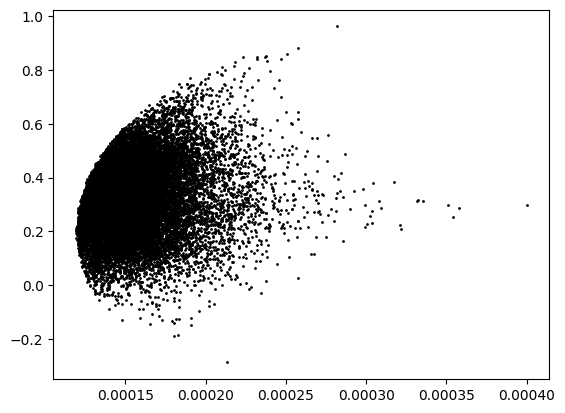

In [33]:
plt.plot(US5_pVar, US5_fp, 'o', color='black', markersize=1)

In [ ]:
def show_Efficient_Frontier(num_stocks, points):
    